In [1]:
# import general purpose models
import pandas as pd
import numpy as np
import os
import math
from datetime import datetime

# package for train and test split
from sklearn.model_selection import train_test_split

# model evaluation package
from sklearn.metrics import mean_squared_error

# import model related packages
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
import cv2

# plot related packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# for preparing tables for Results
from prettytable import PrettyTable

# Configs

In [2]:
base_dir = '/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSets/CS09_SELF_DRIVING_CAR/driving_dataset'
# op to write logs to Tensorboard
logs_dir = './model/logs'
save_dir = './model/save'

# set number of epochs & batch size
num_epochs = 50
batch_size = 128

# set the number of samples for train
data_set_size = -1 # -1 for entire dataset

mp4_output_name = './results/driving_video.mp4'

# Load dataset

In [3]:
def create_path_df(base_dir):

    # declare two lists for input path, label value
    xs = list()
    ys = list()
    
    #read data.txt
    with open(os.path.join(base_dir, 'data.txt')) as f:
        for line in f:
            # get the image path
            xs.append(os.path.join(base_dir, line.split()[0]))
            # convert the angle to radian value
            ys.append(float(line.split()[1]))

    # create a path df and order its column
    path_df = pd.DataFrame({'Path' : xs, 'Label' : ys}, index=range(len(ys)))
    path_df = path_df[['Path', 'Label']]
    

    print('Total images: ', path_df.shape[0])

    return path_df

In [4]:
def load_batch(df, batch_index, batch_size):
    
    # declare a list for holding input images
    x_out = list()
    
    # slice the data frame to required images
    start_index = batch_index * batch_size
    end_index = start_index + batch_size
    
    #print('Start & End index', start_index, end_index)
    
    temp_df = df.iloc[start_index : end_index, :]
    
    # load the images corresponding to the path in the temp_df
    y_out = temp_df['Label'].tolist()
    
    # fetch images one by one
    for index, row in temp_df.iterrows():
        # read the image & crop it
        #img = scipy.misc.imread(row.Path)[-150:]
        img = cv2.imread(row.Path)[-150:]
        # resize image & normalize it
        #img = scipy.misc.imresize(img, [66, 200]) / 255.0
        img = cv2.resize(img, (200, 66,)) / 255.0
        # append to list
        x_out.append(img)
        
    return x_out, y_out   

In [5]:
path_df = create_path_df(base_dir)
path_df.head()

Total images:  45406


,Path,Label
0,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,0.0
1,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,0.0
2,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,0.0
3,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,0.0
4,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,0.0


In [6]:
print('Angles in (Degree) Minimum : %f, Maximum : %f'%(path_df['Label'].min(), 
                                                       path_df['Label'].max()))

Angles in (Degree) Minimum : -159.930000, Maximum : 501.780000


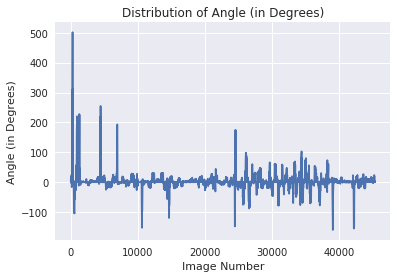

In [7]:
plt.plot(path_df['Label'])
plt.xlabel('Image Number')
plt.ylabel('Angle (in Degrees)')
plt.title('Distribution of Angle (in Degrees)')
plt.show()

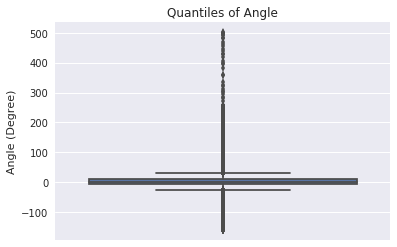

In [8]:
# pick only those angles which is less than 720 degrees (2 rounds of rotation)
path_df = path_df[abs(path_df['Label']) <= 720]
sns.boxplot(data = path_df, y='Label')
plt.ylabel('Angle (Degree)')
plt.title('Quantiles of Angle')
plt.show()

In [9]:
angle_series = path_df['Label']
for percentile in np.arange(0, 1, 0.1):
    per_value = angle_series.quantile(q=percentile)
    print(' %f Percentile = %f'%(percentile * 100.0, per_value,))

 0.000000 Percentile = -159.930000
 10.000000 Percentile = -18.660000
 20.000000 Percentile = -9.380000
 30.000000 Percentile = -2.320000
 40.000000 Percentile = 0.000000
 50.000000 Percentile = 1.010000
 60.000000 Percentile = 2.420000
 70.000000 Percentile = 6.350000
 80.000000 Percentile = 11.500000
 90.000000 Percentile = 21.980000


In [10]:
angle_series = path_df['Label']
for percentile in np.arange(0.9, 1.0, 0.01):
    per_value = angle_series.quantile(q=percentile)
    print(' %f Percentile = %f'%(percentile * 100.0, per_value,))

 90.000000 Percentile = 21.980000
 91.000000 Percentile = 23.700000
 92.000000 Percentile = 25.920000
 93.000000 Percentile = 27.930000
 94.000000 Percentile = 30.026000
 95.000000 Percentile = 34.590000
 96.000000 Percentile = 42.760000
 97.000000 Percentile = 51.030000
 98.000000 Percentile = 65.850000
 99.000000 Percentile = 99.605000


In [11]:
angle_series = path_df['Label']
for percentile in np.arange(0.99, 1.0, 0.001):
    per_value = angle_series.quantile(q=percentile)
    print(' %f Percentile = %f'%(percentile * 100.0, per_value,))

 99.000000 Percentile = 99.605000
 99.100000 Percentile = 113.414550
 99.200000 Percentile = 136.121600
 99.300000 Percentile = 149.750000
 99.400000 Percentile = 166.690000
 99.500000 Percentile = 177.768250
 99.600000 Percentile = 190.690000
 99.700000 Percentile = 200.648500
 99.800000 Percentile = 217.820000
 99.900000 Percentile = 245.760900
 100.000000 Percentile = 501.780000


<h3> Observations </h3>
<ul>
<li> The steering angles at the begining is very large compared to the other . This is expected as the 
     vehicle just stated to move </li>
</ul>

# Convert Angle from Degree to Radian 

In [12]:
# convert the data to radian
scaling_factor = np.pi / 180
path_df['Label'] = path_df['Label'] * scaling_factor

# Train , Validation, Test split of the Data

In [13]:
if data_set_size > 0:
    path_df = path_df.iloc[0:data_set_size]
    
train_df, test_df = train_test_split(path_df, test_size=0.30, shuffle=False)
train_df, val_df = train_test_split(train_df, test_size=0.20, shuffle=False)

In [14]:
print('Number of samples in train data: ', train_df.shape[0])
print('Number of samples in  validation data: ', val_df.shape[0])
print('Number of samples in  test data: ', test_df.shape[0])

Number of samples in train data:  25427
Number of samples in  validation data:  6357
Number of samples in  test data:  13622


In [15]:
train_df.head()

,Path,Label
0,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,0.0
1,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,0.0
2,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,0.0
3,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,0.0
4,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,0.0


In [16]:
val_df.head()

,Path,Label
25427,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,-0.144339
25428,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,-0.140848
25429,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,-0.140848
25430,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,-0.139103
25431,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,-0.139103


In [17]:
test_df.head()

,Path,Label
31784,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,-0.478744
31785,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,-0.494626
31786,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,-0.503353
31787,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,-0.519235
31788,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,-0.542099


# Baseline Time Series Models

## UTILS Functions

## A1) Mean Model

In [18]:
# get the mean angle from train data
mean_angle_train = train_df['Label'].mean()

## A2) Simple Moving Average Model

In [19]:
def Simple_MA_Prediction(value_array, window_size):
    
    # if size less than 2 return as it is
    if len(value_array) < 2:
        return value_array
    
    # initialize predicted value list as empty
    predicted_values = list()
    
    # # process each element in the value list
    for index, value in enumerate(value_array):
        
       # case 1: We have already made atleast window_size predictions
        if index >=  window_size:
            predicted_value = np.mean(value_array[index - window_size : index])
            
        # case 2: We have just started prediction
        else:
            if index == 0:
                predicted_value = value
            else:
                predicted_value = np.mean(value_array[0 : index])
        
        # update the list
        predicted_values.append(predicted_value)
        
    # round the values to integers
    predicted_values = np.array([int(round(item)) for item in predicted_values])
        
        
    return np.array(predicted_values)   

## A3) Weighted Moving Average

In [20]:
def WMA_Predictions(value_array, window_size):
    
    # if size less than 2 return as it is
    if len(value_array) < 2:
        return value_array
    
    # set the denominator
    denominator = (( window_size) * ( window_size + 1)) / 2
    
    # weights array
    window_weight_array = np.array(range(1, window_size + 1)) / denominator
    
    # initialize the predicted value with first element of value list
    predicted_values = list()
    
    # process each element in the value list
    for index, val in enumerate(value_array):
        
        # case 1: we have already made atleast window_size predictions
        if index >=  window_size:
            predicted_value = np.mean(window_weight_array * value_array[index - window_size : index])
            
        # case 2: we have just started prediction
        else:
            
            if index == 0:
                predicted_value = val
            else:
                # set the denominator
                denominator = (index * (index + 1)) / 2
                # weights array
                temp_weight_array = np.array(range(1, index + 1)) / denominator

                predicted_value = np.mean(temp_weight_array * value_array[0 : index])
        
        # update the list
        predicted_values.append(predicted_value)
        
    # round the values to integers
    predicted_values = np.array([int(round(item)) for item in predicted_values])
        
    return predicted_values

## A4) Exponentially Weighted Moving Average

In [21]:
def exp_weighted_MA_Predictions(value_array, alpha):
    
    # if size less than 2 return as it is
    if len(value_array) < 2:
        return value_array
    
    # initialize as empty
    predicted_values = list()
    
    # predict for every time step
    for index, value in enumerate(value_array):
        
        if index > 0:
            predicted = alpha * value_array[index-1] + (1-alpha) * predicted_values[-1]
        else:
            predicted = value_array[0]
         
        # update list
        predicted_values.append(predicted)
        
    # round the values to integers
    predicted_values = np.array([int(round(item)) for item in predicted_values])
        
    return predicted_values

### Hyperparam Tuning Util Functions

In [22]:
def timeseries_model_prediction(df, window_size_sim, window_size_weight, alpha):
    
    # get the angles as a numpy array
    inp_array = df['Label'].values
    
    # get average predictions from all three methods
    
    # get simple moving average prediction
    simp_avg_pred = Simple_MA_Prediction(inp_array, window_size_sim)

    # get weighted moving average prediction
    weighted_avg_pred = WMA_Predictions(inp_array, window_size_weight)

    # get exponentially weighted moving average prediction
    exp_weighted_avg_pred = exp_weighted_MA_Predictions(inp_array, alpha)
    
    # form a return tuple
    ret_tuple = (simp_avg_pred, weighted_avg_pred, exp_weighted_avg_pred,)
    
    return ret_tuple

In [23]:
def find_best_hyperparam(df):
    
    # try 10 different window sizes from 1 to 10
    window_size_list = list(range(1, 11))

    # try differnt alpah values from 0.3 to 0.99
    alpha_val_list = [0.20, 0.30, 0.40, 0.50, 0.65, 
                      0.75, 0.82, 0.90, 0.95, 0.99]
    
    hyp_info_list = list()

    # evaluate each hyp value
    for window_size, alpha in zip(window_size_list, alpha_val_list):
        
        # predict using this hyperparam
        pred_info_tup = timeseries_model_prediction(df, window_size, window_size, alpha)
        
        # get actual values list
        actual_values_list = df['Label'].values
        
        # get predicted values list
        predicted_values_list_sma = pred_info_tup[0]
        predicted_values_list_wma = pred_info_tup[1]
        predicted_values_list_exp = pred_info_tup[2]
        
        # evaluate three models on this hyperparam
        sim_mse = mean_squared_error(actual_values_list, predicted_values_list_sma)
        wm_mse = mean_squared_error(actual_values_list, predicted_values_list_wma)
        exp_mse = mean_squared_error(actual_values_list, predicted_values_list_exp)
        
        # update hyp info list
        hyp_info_list.append((window_size, alpha, sim_mse, wm_mse, exp_mse,))
        
    # create the evaluation df
    eval_df = pd.DataFrame(hyp_info_list, columns=['Window', 'Alpha', 
                                        'SIM_MSE', 'WM_MSE','EXP_MSE'])
    
    # best index
    sim_model_best_index = eval_df['SIM_MSE'].idxmin()
    weight_model_best_index = eval_df['WM_MSE'].idxmin()
    exp_model_best_index = eval_df['EXP_MSE'].idxmin()
    
    print("""Hyper params (Window  for simple, weighted MA,
             Alpha for Exponentailly weighted model) scores df: \n\n\n""", eval_df)
    
    # get the best hyperparam based on the MAPE lowest value
    sim_best_window = eval_df.loc[sim_model_best_index, 'Window']
    weight_best_window = eval_df.loc[weight_model_best_index, 'Window']
    exp_best_alpha = eval_df.loc[exp_model_best_index, 'Alpha']
    
    print('\n'*2)
    
    print('Best Window Size (Hyperparam) for Simple Moiving Average: ', sim_best_window)
    print('Best Window Size (Hyperparam) for Weighted Moiving Average: ', weight_best_window)
    print('Best Alpha (Hyperparam) for Exp. Weighted Moiving Average: ', exp_best_alpha)
    
    
    
    return (sim_best_window, weight_best_window, exp_best_alpha,)

## Run each Base Model

### Run A1

In [24]:
# compute validation & test loss
predicted_train = [mean_angle_train] * train_df.shape[0]
predicted_vals = [mean_angle_train] * val_df.shape[0]
predicted_test = [mean_angle_train] * test_df.shape[0]

# compute MSE from the mean model
mean_model_train_loss = round(mean_squared_error(train_df['Label'], predicted_train), 8)
mean_model_val_loss = round(mean_squared_error(val_df['Label'], predicted_vals), 8)
mean_model_test_loss = round(mean_squared_error(test_df['Label'], predicted_test), 8)

print('Train loss: %f, Validation Loss : %f, Test Loss : %f'%(mean_model_train_loss, 
                                                              mean_model_val_loss, 
                                                              mean_model_test_loss))

Train loss: 0.310709, Validation Loss : 0.320283, Test Loss : 0.242241


### Run A2, A3, A4

### Step 1 : Find best window size

In [25]:
sim_best_window, weight_best_window, exp_best_alpha = find_best_hyperparam(train_df)

Hyper params (Window  for simple, weighted MA,
             Alpha for Exponentailly weighted model) scores df: 


    Window  Alpha   SIM_MSE    WM_MSE   EXP_MSE
0       1   0.20  0.052800  0.052800  0.052793
1       2   0.30  0.049725  0.113120  0.049386
2       3   0.40  0.048355  0.166240  0.049105
3       4   0.50  0.048976  0.199472  0.048947
4       5   0.65  0.050010  0.220973  0.049268
5       6   0.75  0.050239  0.248035  0.050020
6       7   0.82  0.051470  0.272031  0.050854
7       8   0.90  0.052359  0.290254  0.052300
8       9   0.95  0.053458  0.297474  0.052915
9      10   0.99  0.054986  0.298939  0.052816



Best Window Size (Hyperparam) for Simple Moiving Average:  3
Best Window Size (Hyperparam) for Weighted Moiving Average:  1
Best Alpha (Hyperparam) for Exp. Weighted Moiving Average:  0.5


### Step 2 : Predict using best window size

In [26]:
# Predict on Valiation Data
train_actual = train_df['Label'].values
train_predicted_sma = Simple_MA_Prediction(train_actual, sim_best_window)
train_predicted_wma = WMA_Predictions(train_actual, weight_best_window)
train_predicted_ewma = exp_weighted_MA_Predictions(train_actual, exp_best_alpha)


# Predict on Valiation Data
val_actual = val_df['Label'].values
val_predicted_sma = Simple_MA_Prediction(val_actual, sim_best_window)
val_predicted_wma = WMA_Predictions(val_actual, weight_best_window)
val_predicted_ewma = exp_weighted_MA_Predictions(val_actual, exp_best_alpha)

# Predict on Test Data
test_actual = test_df['Label'].values
test_predicted_sma = Simple_MA_Prediction(test_actual, sim_best_window)
test_predicted_wma = WMA_Predictions(test_actual, weight_best_window)
test_predicted_ewma = exp_weighted_MA_Predictions(test_actual, exp_best_alpha)

### Step 3 : Evaluate the performace

In [27]:
# Compute the MSE on train data
train_mse_sma = round(mean_squared_error(train_actual, train_predicted_sma), 8)
train_mse_wma = round(mean_squared_error(train_actual, train_predicted_wma), 8)
train_mse_ewma = round(mean_squared_error(train_actual, train_predicted_ewma), 8)
print('MSE of train data from Models SMA : %f, WMA : %f, EWMA : %f'%(train_mse_sma, 
                                            train_mse_wma, train_mse_ewma,))

# Compute the MSE on validation data
val_mse_sma = round(mean_squared_error(val_actual, val_predicted_sma), 8)
val_mse_wma = round(mean_squared_error(val_actual, val_predicted_wma), 8)
val_mse_ewma = round(mean_squared_error(val_actual, val_predicted_ewma), 8)
print('MSE of validation data from Models SMA : %f, WMA : %f, EWMA : %f'%(val_mse_sma, 
                                            val_mse_wma, val_mse_ewma,))

# Compute the MSE on test data
test_mse_sma = round(mean_squared_error(test_actual, test_predicted_sma), 8)
test_mse_wma = round(mean_squared_error(test_actual, test_predicted_wma), 8)
test_mse_ewma = round(mean_squared_error(test_actual, test_predicted_ewma), 8)
print('MSE of test data from Models SMA : %f, WMA : %f, EWMA : %f'%(test_mse_sma, 
                                            test_mse_wma, test_mse_ewma,))

MSE of train data from Models SMA : 0.048355, WMA : 0.052800, EWMA : 0.048947
MSE of validation data from Models SMA : 0.071728, WMA : 0.075981, EWMA : 0.071352
MSE of test data from Models SMA : 0.052458, WMA : 0.055134, EWMA : 0.053156


In [28]:
row_sma_model = ('Simple-MA', 'Window=%d'%(sim_best_window,), train_mse_sma, 
                 val_mse_sma, test_mse_sma,)
row_wma_model = ('Weighted-MA', 'Window=%d'%(weight_best_window,), train_mse_wma, 
                 val_mse_wma, test_mse_wma,)
row_ewma_model = ('Exp-WMA', 'Alpha=%f'%(exp_best_alpha,) ,train_mse_ewma, 
                  val_mse_ewma, test_mse_ewma,)

# B) CNN Model

## Model Architecture

In [29]:
def build_model(X, keep_prob):

    # First convolutional layer
    W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 3, 24], stddev=0.1))
    b_conv1 = tf.Variable(tf.truncated_normal([24], stddev=0.1))
    net_conv1 = tf.nn.conv2d(X, W_conv1, strides=[1, 2, 2, 1], padding='VALID') + b_conv1
    h_conv1 = tf.nn.relu(net_conv1)


    # Second convolutional layer
    W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 24, 36], stddev=0.1))
    b_conv2 = tf.Variable(tf.truncated_normal([36], stddev=0.1))
    net_conv2 = tf.nn.conv2d(h_conv1, W_conv2, strides=[1, 2, 2, 1], padding='VALID') + b_conv2
    h_conv2 = tf.nn.relu(net_conv2)


    # Third convolutional layer
    W_conv3 = tf.Variable(tf.truncated_normal([5, 5, 36, 48], stddev=0.1))
    b_conv3 = tf.Variable(tf.truncated_normal([48], stddev=0.1))
    net_conv3 = tf.nn.conv2d(h_conv2, W_conv3, strides=[1, 2, 2, 1], padding='VALID') + b_conv3
    h_conv3 = tf.nn.relu(net_conv3)

    # Fourth convolutional layer
    W_conv4 = tf.Variable(tf.truncated_normal([3, 3, 48, 64], stddev=0.1))
    b_conv4 = tf.Variable(tf.truncated_normal([64], stddev=0.1))
    net_conv4 = tf.nn.conv2d(h_conv3, W_conv4, strides=[1, 1, 1, 1], padding='VALID') + b_conv4
    h_conv4 = tf.nn.relu(net_conv4)

    # Fifth convolutional layer
    W_conv5 = tf.Variable(tf.truncated_normal([3, 3, 64, 64], stddev=0.1))
    b_conv5 = tf.Variable(tf.truncated_normal([64], stddev=0.1))
    net_conv5 = tf.nn.conv2d(h_conv4, W_conv5, strides=[1, 1, 1, 1], padding='VALID') + b_conv5 
    h_conv5 = tf.nn.relu(net_conv5)

    # flatten the output layer
    h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])


    #FCL 1
    W_fc1 = tf.Variable(tf.truncated_normal([1152, 1164], stddev=0.1))
    b_fc1 = tf.Variable(tf.truncated_normal([1164], stddev=0.1))
    net_fc1 = tf.matmul(h_conv5_flat, W_fc1) + b_fc1
    h_fc1 = tf.nn.relu(net_fc1)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    #FCL 2
    W_fc2 = tf.Variable(tf.truncated_normal([1164, 100], stddev=0.1))
    b_fc2 = tf.Variable(tf.truncated_normal([100], stddev=0.1))
    net_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    h_fc2 = tf.nn.relu(net_fc2)
    h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

    #FCL 3
    W_fc3 = tf.Variable(tf.truncated_normal([100, 50], stddev=0.1))
    b_fc3 = tf.Variable(tf.truncated_normal([50], stddev=0.1))
    net_fc3 = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
    h_fc3 = tf.nn.relu(net_fc3)
    h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)


    #FCL 4
    W_fc4 = tf.Variable(tf.truncated_normal([50, 10], stddev=0.1))
    b_fc4 = tf.Variable(tf.truncated_normal([10], stddev=0.1))
    net_fc4 = tf.matmul(h_fc3_drop, W_fc4) + b_fc4
    h_fc4 = tf.nn.relu(net_fc4)
    h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)


    #Output
    W_fc5 = tf.Variable(tf.truncated_normal([10, 1], stddev=0.1))
    b_fc5 = tf.Variable(tf.truncated_normal([1], stddev=0.1))
    net_fc5 = tf.matmul(h_fc4_drop, W_fc5) + b_fc5


    # declare final output layer
    #y_ = tf.atan(net_fc5) * 2 #scale the atan output
    y_ = net_fc5
    
    return y_

In [30]:
def train_model(train_df, val_df):
    
    # Declare input, output layers size
    X = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
    y = tf.placeholder(tf.float32, shape=[None, 1]) # since it is a regression problem
    
    # declare dropout var
    keep_prob = tf.placeholder(tf.float32)

    # load the model architecture
    y_ = build_model(X, keep_prob)
    
    # define loss
    loss = tf.reduce_mean(tf.square(tf.subtract(y, y_))) 
    
    print('X', X)
    print('y', y)
    print('keep_prob', keep_prob)
    print('y_', y_)
    print('loss', loss)
    

    # declare a train step
    train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)

    # declare a saver for saving the checkpoints (save only the best model)
    saver =  tf.train.Saver(write_version = saver_pb2.SaverDef.V1)
    
    # compute the number of batches
    num_train_batches = math.ceil(train_df.shape[0] / batch_size)
    num_val_batches = math.ceil(val_df.shape[0] / batch_size)
    

    print('Number of train batches: %d, validation batches : %d\n\n'%(num_train_batches, 
                                                                  num_val_batches,))
    
    
    print('=' * 40 ,datetime.now(),  ' Training Started ', '='*40, '\n\n')
    
    # initialize mean validation loss
    prev_mean_val_loss = np.inf
    
    global_step = 0
    
    # open a session and run the graph
    with tf.Session() as sess:
        
        # initialize all variables
        sess.run(tf.global_variables_initializer())
        
        # declare two lists for saving losess train & validation (epoch-wise)
        epoch_train_loss_list = list()
        epoch_val_loss_list = list()

        # run each training epoch
        for epoch in range(num_epochs):
            
            print(datetime.now(), ' Training epoch: {}'.format(epoch + 1))
            
            
            # declare two lists for saving losess train & validation (batch-wise)
            batch_train_loss_list = list()
            batch_val_loss_list = list()
            
            # set validation id as zero
            val_batch_id = 0
            
            # run for every batch in this epoch
            for tr_batch_id in range(num_train_batches):
                
                # load train batch data & train it
                xs, ys = load_batch(train_df, tr_batch_id, batch_size)
                ys = list(np.array(ys).reshape(-1,1))
                
                # trian on this batch
                _ , tr_loss = sess.run([train_step, loss], 
                             feed_dict={X: xs, y: ys, keep_prob: 0.8})
                
                # increment global step count
                global_step = global_step + 1
                
                # insert the loss to train loss list
                batch_train_loss_list.append(tr_loss)
           
            # compute the mean train loss
            mean_train_loss = np.mean(batch_train_loss_list)
        
            # Evaluate validation loss batch-wise
            for val_batch_id in range(num_val_batches):
                
                # load train batch data & train it
                xs, ys = load_batch(val_df, val_batch_id, batch_size)
                ys = list(np.array(ys).reshape(-1,1))
                
                # trian on this batch
                val_loss = sess.run([loss], feed_dict={X: xs, y: ys, keep_prob: 1.0})
                
                # insert the loss to train loss list
                batch_val_loss_list.append(val_loss)
                
            # compute the mean train loss
            mean_val_loss = np.mean(batch_val_loss_list)
            
            
            # update the loss list declared for epochs
            epoch_train_loss_list.append(mean_train_loss)
            epoch_val_loss_list.append(mean_val_loss)
            
            
            # check if validation score improved or not, if yes save the model    
            if mean_val_loss < prev_mean_val_loss: 
                # update previous mean val loss
                prev_mean_val_loss = mean_val_loss

                # write the checkpoint files to disk
                checkpoint_path = os.path.join(save_dir, 'model.ckpt')
                filename = saver.save(sess, checkpoint_path)
                print(datetime.now(),' Validation loss improved, Model saved in file: %s'%(filename,))
        

    return (epoch_train_loss_list, epoch_val_loss_list,)

In [31]:
def test_model(test_df):
    
    # set the number of batches
    num_test_batches = math.ceil(test_df.shape[0] / batch_size) 
    
    # Evaluate the model on Test dataset
    batch_test_loss_list = list()
    predicted_list = list()
     
    # open a session
    with tf.Session() as sess:  
        
        #First let's load meta graph and restore weights
        saver = tf.train.import_meta_graph(os.path.join(save_dir, 'model.ckpt.meta'))
        saver.restore(sess, tf.train.latest_checkpoint(save_dir))

        print('Model restored successfully ...')
        
        # get input & output
        graph = tf.get_default_graph()
        X = graph.get_tensor_by_name('Placeholder:0')
        y = graph.get_tensor_by_name('Placeholder_1:0')
        keep_prob = graph.get_tensor_by_name('Placeholder_2:0')
        y_ = graph.get_tensor_by_name('add_9:0')
        loss = graph.get_tensor_by_name('Mean:0')
        
        print('Fetching All tensors Completed ...')
        
        # run test batch by batch                                   
        for test_batch_id in range(num_test_batches):

            # load train batch data & train it
            xs, ys = load_batch(test_df, test_batch_id, batch_size)
            ys = list(np.array(ys).reshape(-1,1))
                                           
            # trian on this batch
            test_predicted, test_loss = sess.run([y_, loss], feed_dict={X: xs, y: ys, 
                                                                        keep_prob: 1.0})
            
            predicted_list.extend(list(test_predicted.flatten()))

            # insert the loss to train loss list
            batch_test_loss_list.append(test_loss)

        # compute the mean train loss
        mean_test_loss = np.mean(batch_test_loss_list)
        print('Test loss (MSE) mean of all batches: ', mean_test_loss)
        
        print('Done !!!')
        
        return (mean_test_loss, predicted_list,)

In [32]:
cnn_tr_loss_list, cnn_val_loss_list = train_model(train_df, val_df)

X Tensor("Placeholder:0", shape=(?, 66, 200, 3), dtype=float32)
y Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
keep_prob Tensor("Placeholder_2:0", dtype=float32)
y_ Tensor("add_9:0", shape=(?, 1), dtype=float32)
loss Tensor("Mean:0", shape=(), dtype=float32)
Number of train batches: 199, validation batches : 50


======================================== 2019-06-23 01:42:15.779995  Training Started  ======================================== 


2019-06-23 01:42:15.860833  Training epoch: 1
2019-06-23 02:01:16.126146  Validation loss improved, Model saved in file: ./model/save/model.ckpt
2019-06-23 02:01:16.126377  Training epoch: 2
2019-06-23 02:05:58.203249  Training epoch: 3
2019-06-23 02:10:40.169323  Training epoch: 4
2019-06-23 02:15:22.087529  Training epoch: 5
2019-06-23 02:20:04.020628  Training epoch: 6
2019-06-23 02:24:46.210286  Training epoch: 7
2019-06-23 02:29:29.537741  Training epoch: 8
2019-06-23 02:34:11.284825  Training epoch: 9
2019-06-23 02:38:53.408465  Tra

In [33]:
cnn_test_loss, cnn_predicted_list_test = test_model(test_df)
cnn_test_loss = round(cnn_test_loss, 8)

INFO:tensorflow:Restoring parameters from ./model/save/model.ckpt
Model restored successfully ...
Fetching All tensors Completed ...
Test loss (MSE) mean of all batches:  0.23867664
Done !!!


# Plot Train vs Validation losess

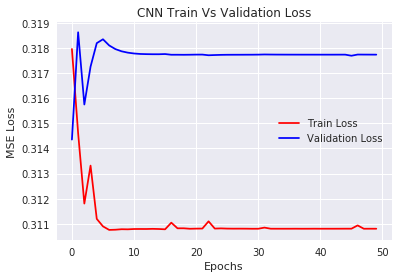

In [34]:
plt.plot(list(range(len(cnn_tr_loss_list))), cnn_tr_loss_list, label='Train Loss', color='r')
plt.plot(list(range(len(cnn_val_loss_list))), cnn_val_loss_list, label='Validation Loss', color='b')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('CNN Train Vs Validation Loss')
plt.show()

<h3> Observations </h3>
<ul>
<li> Validation loss tends plateau after epoch 10</li>
<li> Train loss keeps decreasing over epoch </li>
<li> Early stopping is used to pick the best model, the model is saved only if the loss is improved </li>
</ul>

# Save Driving Video File

In [35]:
test_df = test_df[['Path', 'Label']]
print('Number of predicted angles', len(cnn_predicted_list_test))
print('Test df shape', test_df.shape)

Number of predicted angles 13622
Test df shape (13622, 2)


### Add the predicted labels to the data frame

In [36]:
test_df['Predicted_Radian'] = cnn_predicted_list_test
# convertt to angle
test_df['Predicted_Degree'] = test_df['Predicted_Radian'] * (180 / np.pi) 
test_df.head()

,Path,Label,Predicted_Radian,Predicted_Degree
31784,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,-0.478744,0.015313,0.877369
31785,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,-0.494626,0.014013,0.802885
31786,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,-0.503353,0.011122,0.637258
31787,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,-0.519235,0.016339,0.936142
31788,/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSe...,-0.542099,0.014668,0.840434


In [37]:
def save_driving_video(test_df):
    
    # Read steering wheel image
    steering_img = cv2.imread('steering_wheel_image.jpg',0)
    steering_rows, steering_cols = steering_img.shape
    
    # set font size for text
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    # padding for steering
    padding = np.zeros((8, 240, 3))
    height, width, = 256, 695
    size = (width, height)
    
    smoothed_angle = 0
    
    # declare an videocapture object
    vid_out = cv2.VideoWriter(mp4_output_name, cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
    
    # for 
    for index, row in test_df.iterrows():
        # set road image path
        img_road = cv2.imread(row.Path)
        # get predicted degree
        degrees = row.Predicted_Degree
        # rotate the steering
        smoothed_angle += (0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * 
                           (degrees - smoothed_angle) / abs(degrees - smoothed_angle))

        M = cv2.getRotationMatrix2D((steering_cols/2,steering_rows/2),-smoothed_angle,1)
        dst = cv2.warpAffine(steering_img, M, (steering_cols,steering_rows))
        
        # padded sequence 
        stacked_img = np.stack((dst,)*3, axis=-1)
        padded_steering = np.concatenate([padding, stacked_img, padding])
        
        # combine steering & road image
        combined_img = np.concatenate([img_road, padded_steering], axis=1)
        
        # add text to the data
        cv2.putText(img=combined_img, text='{0:.4f} o'.format(degrees), org=(500,128), 
                    fontFace=font, fontScale=1.0, 
                    color=(0, 0, 255), thickness=5)
        
        # write & read the image back
        cv2.imwrite('temp.jpg', combined_img)
        combined_img = cv2.imread('temp.jpg')
        
        #print(combined_img.shape)
        vid_out.write(combined_img)
        
    vid_out.release()

In [38]:
save_driving_video(test_df)

# Results

In [39]:
# get CNN mean value of loss train, validation
cnn_train_loss = round(np.mean(cnn_tr_loss_list), 8)
cnn_val_loss = round(np.mean(cnn_val_loss_list), 8)

row_mean_model = ('Mean Model', 'array size:N', mean_model_train_loss, mean_model_val_loss, 
                  mean_model_test_loss,)
row_cnn_model = ('CNN Model', '5 Convs, 5 FCL,\n Linear output', cnn_train_loss, 
                 cnn_val_loss, cnn_test_loss,)

In [40]:
Pret_table = PrettyTable()
Pret_table.field_names = ['Model', 'Hyper Param', 'Train MSE', 'Validation MSE', 'Test MSE']
Pret_table.title = 'Self Driving Car - MSE of Models'

# basic time series model results
Pret_table.add_row(row_mean_model)
Pret_table.add_row(row_sma_model)
Pret_table.add_row(row_wma_model)
Pret_table.add_row(row_ewma_model)

# CNN model result
Pret_table.add_row(row_cnn_model)
print(Pret_table)

+--------------------------------------------------------------------------+
|                     Self Driving Car - MSE of Models                     |
+-------------+-----------------+------------+----------------+------------+
|    Model    |   Hyper Param   | Train MSE  | Validation MSE |  Test MSE  |
+-------------+-----------------+------------+----------------+------------+
|  Mean Model |   array size:N  | 0.31070876 |   0.32028271   | 0.24224142 |
|  Simple-MA  |     Window=3    | 0.04835476 |   0.07172848   | 0.05245807 |
| Weighted-MA |     Window=1    | 0.05280013 |   0.07598096   | 0.05513379 |
|   Exp-WMA   |  Alpha=0.500000 | 0.04894741 |   0.07135225   | 0.05315572 |
|  CNN Model  | 5 Convs, 5 FCL, | 0.3111167  |   0.31766912   | 0.23867664 |
|             |   Linear output |            |                |            |
+-------------+-----------------+------------+----------------+------------+


# Procedure Summary

<ul>
<li> Basic EDA is done on the steering anlge </li>
<li> Classical time series models such as simple moving average, weigted moving averge
     exponentially weighted moving average are used as reference models. </li>
<li> The dataset is partioned into batches considering the timestamp order </li>
<li> CNN Architecute is designed </li>
<li> The angle is conveted into radian (number format) from degrees .</li>
<li> Hyperparam tuning is done for classical time series models</li>
<li> Testing of classical time series models are done </li>
<li> Training & testing of CNN is done </li>
<li> The train, validation loss is plotted for CNN </li>
</ul>

# Conclusion

<li> The classical time series model outperformed CNN model </li>
<li> The CNN model is slightly better than mean model </li>
<li> The input to CNN is fed based on time step order </li>
<li> The performace of CNN is not great when compared to classical time series model, this is 
     expected as the CNN totally ignores the time sequence inforamtion</li>
<li> Given a single image it is difficult to make a decision to turn left or right, we need to consider  
     few previous images and also buffer few upcoming images in order to decide whether to turn left or right </li>
<li> The models which can handle time series information can be used to improve the MSE further.</li>
<li> LSTM model which uses CNN features can be used to improve the performace </li>
<li> The architecture & hyperparam of CNN can be tuned to furter improve the results </li>
</ul>